# $k$-Nearest-Neighbors

> 
>
> **Author:** Bjarne C. Hiller

## Ingredients

- Math
    - Distance Metrics
    - Matrix Operations
- NumPy
    - [Broadcasting in NumPy](https://numpy.org/doc/stable/user/basics.broadcasting.html)
    - `np.argsort`
    - `np.argmax`
    - `np.bincount`
    - `np.apply_along_axis`
- scikit-learn
    - [`sklearn.LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

## Keypoints of KNNs

Let's start with an example:
Consider the following problem: We have data about some people, including their geographic location of residency and their nationality.
Now, we want to predict the nationality of new people based on their geolocation.
In this case, the nationality becomes the label of each data point, while the geolocation is the feature.
Intuitively, it makes sense to look at the nationality of their known *neighbors*, since the likelihood is high that they live close to people with the same nationality, right?

This is the core assumption of the k-Nearest Neighbor (KNN) algorithm: *instances of the same class are close to each other within the feature space.*

We will use the Euclidean Distance, which describes the length of a line segment connecting the 2 points:

$$
    d(\mathbf{x}, \mathbf{y}) = \lVert \mathbf{x} - \mathbf{y} \rVert_2 = \sqrt{\sum_{i=0}^d (x_i - y_i)^2}
$$

Euclidean distance is good, when features are measuring similar things.
Use Normalization to ensure, that the distances between features is equal.

A $k$-NN estimator is a *non-parametric* model.
They belong to the category of **instance-based** or **memory-based learning**.

# Implementation

In [1]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import DecisionBoundaryDisplay

How does Broadcasting work in Numpy?

In [2]:
import numpy as np

A = np.random.randn(6,2)
B = np.random.randn(4,2)

(A[:, np.newaxis, :] - B).shape

(6, 4, 2)

> Implement a function `distance_matrix(P,Q)`, that computes the pairwise Euclidean distances between 2 point sets P and Q!

In [3]:
def distance_matrix(A, B):
    """
    Computes pairwise euclidean distances between points.

    :param A: point array (n, d)
    :param B: point array (m, d)
    :returns: pairwise distance matrix (n,m) 
    """
    # repeat A m times to receive (n,m,d)
    A = A[:, np.newaxis, :]

    # numpy broadcasting magic!
    D = A - B

    # Euclidean Distance
    D = np.power(D, 2)
    D = np.sum(D, axis=-1)
    D = np.sqrt(D)
    return D
    
D = distance_matrix(A, B)

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit_transform(["apple", "orange", "pear", "apple"])

array([0, 1, 2, 0])

In [5]:
rank = np.argsort(D, axis=1)[:, :1]

y = np.array(["A", "B", "C", "D", "E", "F"])
y[rank]

array([['C'],
       ['C'],
       ['C'],
       ['B'],
       ['C'],
       ['C']], dtype='<U1')

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k=1):
        self.k = k
        # sklearn convention: fields ending on underscores (_) are computed during fit
        self.X_train_ = None
        self.y_train_ = None
        self.classes_ = None
        self.le_ = None
    
    def fit(self, X, y):
        # store training data
        self.X_train_ = X
        self.y_train_ = y
        self.le_ = LabelEncoder()
        self.le_.fit(y)
        self.classes_ = self.le_.classes_
 
    def _predict(self, X):
        """For m points, returns label counts (m,c) over c classes among the k nearest neighbors."""
        # compute pairwise distances between train and test
        D = distance_matrix(X, self.X_train_)

        # get sorted indices
        rank = np.argsort(D, axis=1)

        # use only top k ranks
        rank = rank[:, :self.k]

        # get labels (n,k) associated with k closest train points
        y = self.y_train_[rank]

        # for k>1, we need to count label occurences
        y = np.apply_along_axis(self.le_.transform, 1, y)

        # count label occurences along axis 1
        n = len(self.le_.classes_)
        counts = np.apply_along_axis(np.bincount, 1, y, minlength=n)
        return counts
    
    def predict(self, X):
        """Most frequent label among k nearest neighbors."""
        counts = self._predict(X)
        prediction = np.argmax(counts, axis=1)
        prediction = self.le_.inverse_transform(prediction)
        return prediction
    
    def predict_proba(self, X):
        """Relative label frequencies among k nearest neighbors."""
        counts = self._predict(X)
        return counts / np.sum(counts, axis=1, keepdims=True)

## Visualize Decision Boundaries

For $k=1$, the decision boundary of the KNN presents a [*Voronoi partition*](https://en.wikipedia.org/wiki/Voronoi_diagram) of the feature space given the training points:

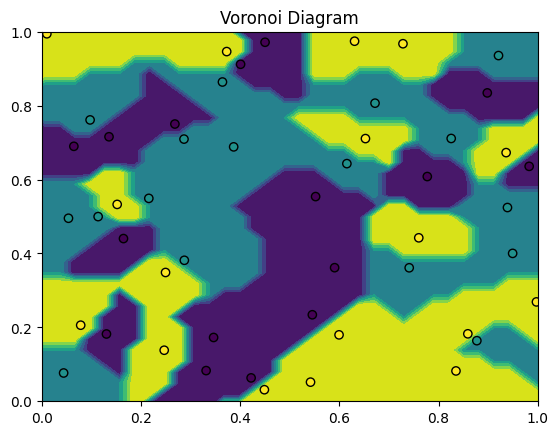

In [7]:
np.random.seed(19)

n = 50


X = np.random.uniform(0, 1, size=(n,2))
y = np.random.choice([1, 2, 3], n)

fig, ax = plt.subplots()

model = KNN(k=1)
model.fit(X, y)

DecisionBoundaryDisplay.from_estimator(model, X, ax=ax)

plt.scatter(X[:,0], X[:,1], c=y, edgecolors=["k"])
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Voronoi Diagram");

## Test on Iris Dataset

In [8]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris_ds = load_iris()

# use petal length and petal width as features
X = iris_ds["data"][:,[2,3]]
y = iris_ds["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=19)

In [9]:
from sklearn.metrics import accuracy_score

model = KNN(k=1)
model.fit(X_train, y_train)

y_hat = model.predict(X_test)

accuracy_score(y_test, y_hat)

1.0

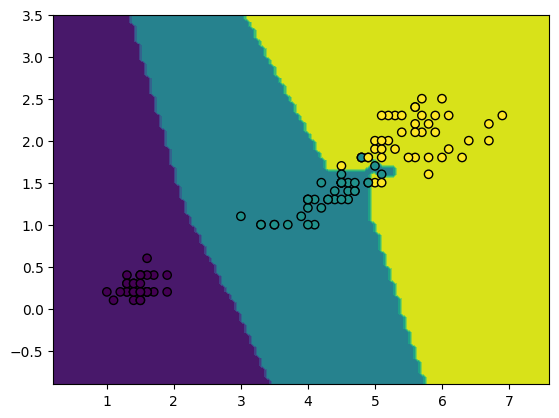

In [10]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

fig, ax = plt.subplots()

display = DecisionBoundaryDisplay.from_estimator(model, X_test, ax=ax)

ax.scatter(X_train[:,0], X_train[:,1], c=y_train, edgecolors="k")
plt.show()

## Curse of Dimensionality

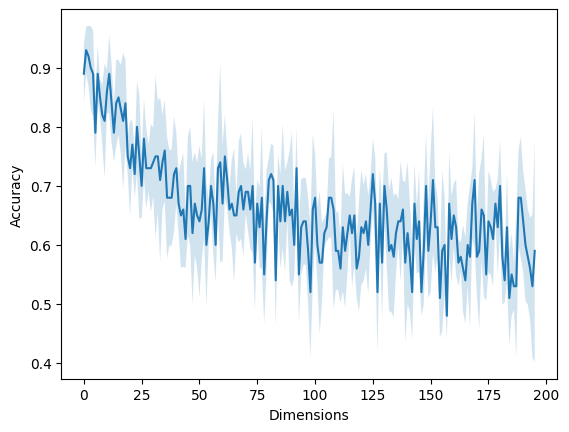

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

scores = []
for d in range(4, 200):
    X, y = make_classification(n_samples=100, n_classes=2, n_features=d, n_informative=2, n_redundant=0, n_repeated=0, random_state=19)
    # model = KNeighborsClassifier(n_neighbors=5)
    model = KNN(k=5)
    score = cross_val_score(model, X, y)
    scores.append(score)

scores = np.stack(scores)
mu = scores.mean(axis=1)
sigma = scores.std(axis=1)

plt.fill_between(x=np.arange(len(mu)), y1=mu-sigma, y2=mu+sigma, alpha=0.2)
plt.plot(scores.mean(axis=1))
plt.xlabel("Dimensions")
plt.ylabel("Accuracy");

## The Probabilistic Perspective

Unsurprisingly, there is also a probabilistic motivation to KNNs, providing insight why they work.

Let's assume we have positive samples $X_1, ..., X_m \sim f(x)$ and negative samples $Y_1, ..., Y_n \sim g(y)$.
Here, $f(x)$ and $g(y)$ denote the respective *Probability Density Functions* (PDF) of our positive and negative class.
Combining the samples $X$ and $Y$ leaves us with our collected training data $Z_1, ..., Z_{m+n}$.


Now, we want to classify a new point $z$.
Should we assign a positive or a negative label?
Therefore, we can compare the likelihoods of the new point regarding the class densities $f(z)$ and $g(z)$.
Let's consider the likelihood ratio:

$$
    l(z) = \frac{f(z)}{g(z)}
$$

If $l(z) > 1$, the probability density of the positive class $f(z)$ is higher at the new point $z$ and we will therefore assign a positive label.
Otherwise, $g(z)$ is higher and we will label $z$ as negative.

But how do we actually get the PDFs?
While the true PDFs, are usually unknown to us, we can approximate them as $\hat{f}$ and $\hat{g}$ from our training data.
Therefore, we can use a really basic *Kernel Density Estimation* (KDE):

$$
    \begin{align*}
        \hat{f}(x) &= m^{-1} \sum_{i=0}^m K_\Delta (X_i - x) &
        \hat{g}(y) &= n^{-1} \sum_{i=0}^n K_\Delta (Y_i - y)
    \end{align*}
$$

Here, our Kernel Function $K_\Delta$ is a uniform PDF around zero within a neighborhood $\Delta$.
We respectively divide by $m$ and $n$ to ensure, that $\hat{f}$ and $\hat{g}$ integrate to $1$ and therefore are valid PDFs.
Besides a normalizing constant, those approximated PDFs could be computed by just counting the amount of points within 

The important part is now to select the right distance $\Delta$:
If it is too big, we are oversmoothing our data.
If it is too small, we might end up with no training samples within the given neighborhood.

The solution is to consider a dynamic neighborhood distance, until we have exactly $k$ points within our neighborhood!
Then, we are considering a larger neighborhood in regions with low sample density, and a smaller neighborhood in regions with high sample density.

Let's denote the distance from point $z$ to the $k$-th closest $Z_i$ with $d_k(z)$.
We also introduce a indicator function $\delta$, with:

$$
    \delta_i = 
    \begin{cases}
        1 & Z_i \in X \\
        0 & Z_i \in Y \\
    \end{cases}
$$

Using Bayes' Law to estimate the posterior $p(\delta = 1 | Z = z)$, we end up with:

$$
    \begin{align*}
        p(\delta = 1 | Z = z) &= \frac{p(z | \delta = 1) p(\delta = 1)}{p(z | \delta = 1) p(\delta = 1) + p(z | \delta = 0) p(\delta=0)} \\
        &= \frac{\hat{f}(z) \frac{m}{m+n}}{\hat{f}(z) \frac{m}{m+n} + \hat{g}(z) \frac{n}{m+n}} \\
        &= \frac{\sum_{i=1}^{m+n} \delta_i K[(Z_i - z) / d_k(z) ]}{\sum_{i=1}^{m+n} \delta_i K[(Z_i - z) / d_k(z)] + \sum_{j=1}^{m+n} (1-\delta_j) K[(Z_j - z) / d_k(z)]} \\
        &= \frac{\sum_{i=1}^{m+n} \delta_i K[(Z_i - z) / d_k(z) ]}{\sum_{i=1}^{m+n} K[(Z_i - z) / d_k(z)]}
    \end{align*}
$$

Note how the $m / (m+n)$ and $n / (m+n)$ normalization terms disappear: $1/(m+n)$ can be factorialized and dropped from the fraction, while the $n$ and $m$ coefficients cancel out with the density normalization

Finally, for a uniform Kernel function K, we end up with the ratio of positive instances within the neighborhood vs k, where $\mathbf{1}$ denotes the *indicator function*:

$$
    p(\delta = 1 | Z=z) = \frac{\sum_{i=1}^{m+n} \delta_i \mathbf{1}\{(Z_i - z) \leq d_k(z)\}}{k}
$$

We just derived how our KNN classifies new instances!

## References

- [sklearn KNN](https://scikit-learn.org/stable/modules/neighbors.html#classification)
- [Wikipedia: KNN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)
- [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram)
- [Fix, Evelyn, and J. L. Hodges. “Discriminatory Analysis. Nonparametric Discrimination: Consistency Properties.”](https://doi.org/10.2307/1403797)
    - introduced $k$-Nearest Neighbar estimation in 1951
- [Silverman, B. W., and M. C. Jones. “E. Fix and J.L. Hodges (1951): An Important Contribution to Nonparametric Discriminant Analysis and Density Estimation: Commentary on Fix and Hodges (1951).”](https://doi.org/10.2307/1403796)